Notebook for final measurements of emmsion line dvs, including re-extracted older spectra.

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [17]:
lines = [8498.02,8542.09,8662.14]
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')
sp2 = glob.glob('stare_extractions/*VIS*.csv')
sp = np.hstack((sp, sp2))


In [22]:
line_list = Table.read('line_positions.ecsv')
print (len(line_list[line_list['Xs'] !=  -1.0]))
line_list = line_list[line_list['Xs'] !=  -1.0]
sp_lines, xs = line_list['FILENAME'], line_list['Xs']

26


In [13]:
def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])

def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 10
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne
    
    
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error
#get_shifted_lines(xs[0], lines)

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_30_TAC.csv


/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_16_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_14_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_8_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_1_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_11_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_12_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_31_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ11440

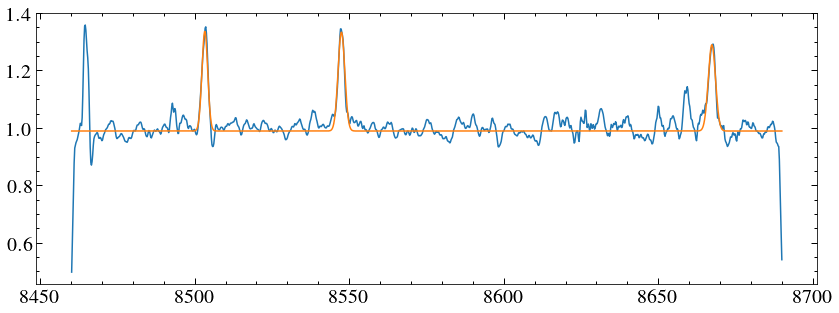

stare_extractions/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_58168.257472311.csv


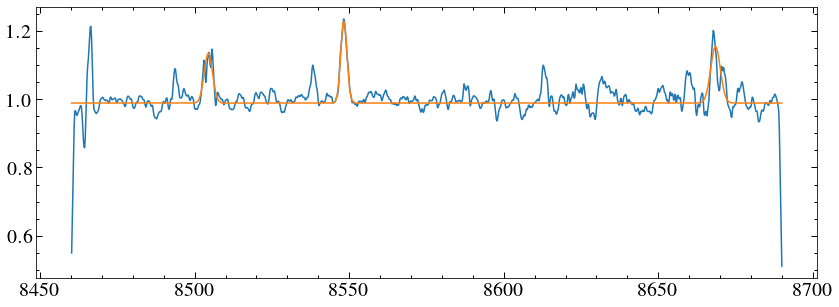

stare_extractions/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_58189.08029528.csv


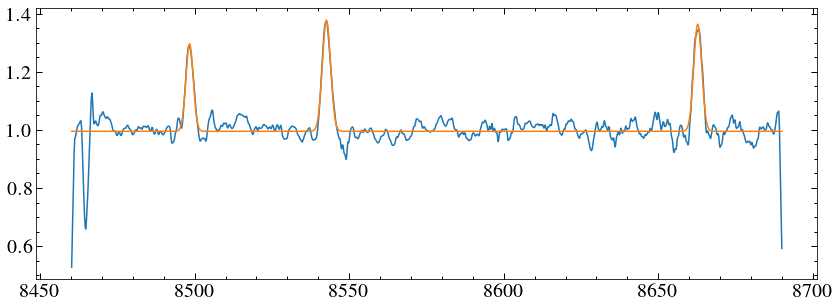

stare_extractions/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_58189.097731213.csv


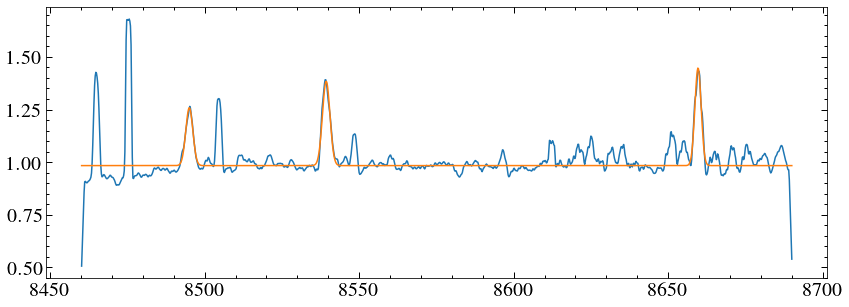

In [42]:
fitter = fitting.LevMarLSQFitter()
dvs = []
dves = []
dates = []
for s, x in zip(sp_lines, xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] +  (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
    dates.append(date)
    
    
  #  plt.figure() 
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
   #     plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    if 'stare_extractions' in s:
        plt.plot(w, f)
        plt.plot(w, gg_fit(w))
        plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
    #print(len(es))
    dv, dve = dv_average(dv, es)
    dvs.append(dv)
    dves.append(dve)

<ErrorbarContainer object of 3 artists>

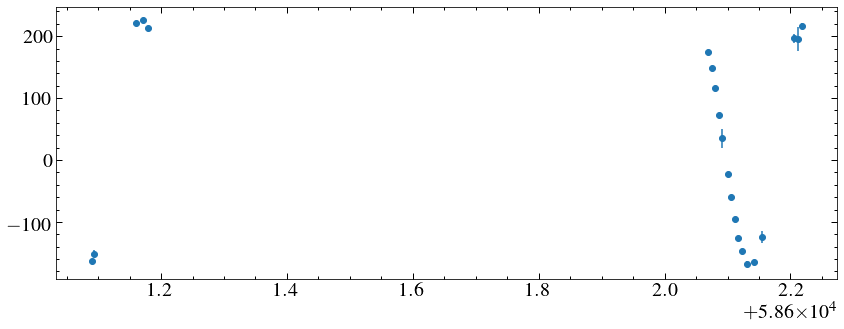

In [33]:
plt.errorbar(dates[:-5], dvs[:-5], yerr=dves[:-5], marker='o', ls='none')

In [43]:
dates = np.array(dates)
args = np.argsort(dates)
t = dates[args]
dvs = np.array(dvs)[args]
dves= np.array(dves)[args]
#t_unnorm = t*24
#t = (t-t[0])*24
t *= 24


In [74]:
import math
nights = np.array([math.floor(date) for date in dates])[args]
print(nights)
cols =  []
for i , n in enumerate(np.unique(nights)):
    for night in nights:
        if night == n:
            cols.append('C{}'.format(i))
cols = np.array(cols)
print(cols)

[58168 58168 58189 58189 58601 58601 58601 58601 58601 58602 58602 58602
 58602 58602 58602 58602 58602 58602 58602 58602 58602 58602 58602 58602
 58602 58602]
['C0' 'C0' 'C1' 'C1' 'C2' 'C2' 'C2' 'C2' 'C2' 'C3' 'C3' 'C3' 'C3' 'C3'
 'C3' 'C3' 'C3' 'C3' 'C3' 'C3' 'C3' 'C3' 'C3' 'C3' 'C3' 'C3']


4.225117143350449


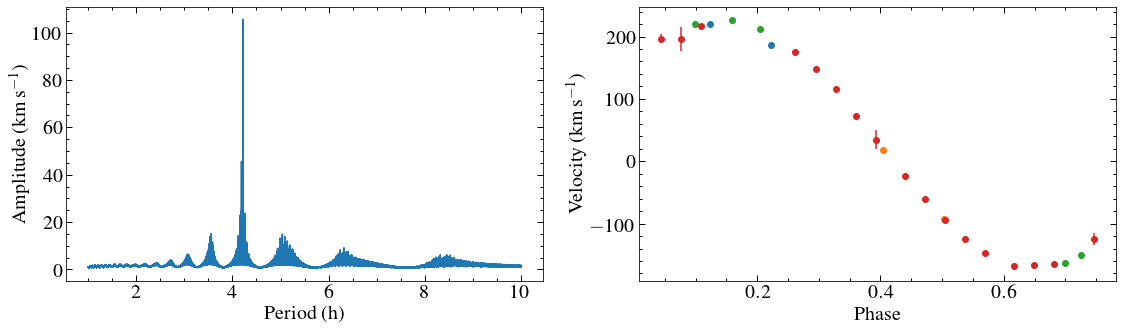

In [90]:
#peak_collection = np.load('fake_peaks_emission.npy')
#fa99 = np.percentile(peak_collection, 99)
#frequency = np.linspace(1/5, 1/3, 1000fa99 = np.percentile(peak_collection, 99)00)
#power = LombScargle(t, dvs,dy=dves, normalization='model').power(frequency)
frequency, power = LombScargle(t, dvs,dy=dves, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)
period = 1/frequency[np.argmax(power)]
print(period)

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(1/frequency, np.sqrt(power))
plt.xlabel('Period (h)')
plt.ylabel('Amplitude (km\,s$^{-1}$)')
#plt.axhline(np.sqrt(fa99), ls='--', c='0.5')

plt.subplot(122)
for i in range(len(t)):
    plt.errorbar((t[i]/period %1), dvs[i], yerr=dves[i], marker='o', ls='none', color=cols[i])
plt.xlabel('Phase')
plt.ylabel('Velocity (km\,s$^{-1}$)')
plt.tight_layout()

In [91]:
#note FAP calculated by this method was too low to be useful

"""n = 10000
peak_collections = []
check = np.arange(500, n+1, 500)

i = 0
max_peak = []
while i < n:
    i+=1
    arr = np.array(dvs)
    np.random.shuffle(arr)
    
    fake_frequency, fake_power = LombScargle(t, arr, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)
    max_peak.append(max(fake_power))
    if i in check:
        print(i)
peak_collections.append(max_peak)

np.save('fake_peaks_emission', np.array(peak_collections))"""

"n = 10000\npeak_collections = []\ncheck = np.arange(500, n+1, 500)\n\ni = 0\nmax_peak = []\nwhile i < n:\n    i+=1\n    arr = np.array(dvs)\n    np.random.shuffle(arr)\n    \n    fake_frequency, fake_power = LombScargle(t, arr, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)\n    max_peak.append(max(fake_power))\n    if i in check:\n        print(i)\npeak_collections.append(max_peak)\n\nnp.save('fake_peaks_emission', np.array(peak_collections))"

Can we fit the dv data without folding this time?

58.68150684821674
167.30564741994266
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=154.90443636, frequency=0.23667922, phase=0.18446455)>

    [1]: <Const1D(amplitude=27.45449337)>
Parameters:
       amplitude_0        frequency_0           phase_0          amplitude_1    
    ------------------ ------------------ ------------------- ------------------
    154.90443636150252 0.2366792181058647 0.18446455382958366 27.454493369016493
4.225128036178943


(1406400, 1406500)

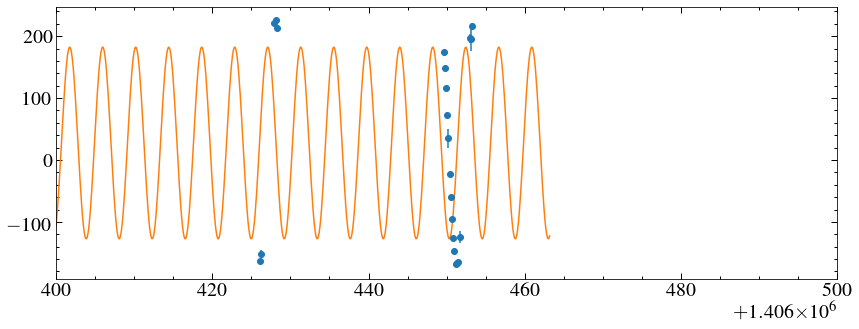

In [107]:
fitter = fitting.LevMarLSQFitter()
    
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
v_offset = max(dvs)-abs(min(dvs))
print(v_offset)
print(max(dvs)-v_offset)
#sin_mod =  models.Sine1D(amplitude=max(dvs)-v_offset, frequency=1/period) +  models.Const1D(v_offset)
sin_mod =  models.Sine1D(amplitude=100, frequency=1/period) +  models.Const1D(50)
sin_fit = fitter(sin_mod, t, dvs, weights= 1/dves, maxiter=1000000)
timefit = np.arange(t[0]-10,t[-1]+10, 0.1)
plt.plot(timefit, sin_fit(timefit))
plt.xlim()
print(sin_fit)
print(1/sin_fit[0].frequency)
#plt.xlim(58601, 58602.5)
#plt.xlim(58167, 58191)
plt.xlim(1406400,1406500 )

Looks like we're folding then fitting, huh.

58.68150684821674
167.30564741994266
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=197.3720162, frequency=1., phase=0.10112108)>

    [1]: <Const1D(amplitude=26.92188675)>
Parameters:
       amplitude_0     frequency_0       phase_0          amplitude_1    
    ------------------ ----------- ------------------- ------------------
    197.37201619998925         1.0 0.10112107672088312 26.921886749526752
1.0


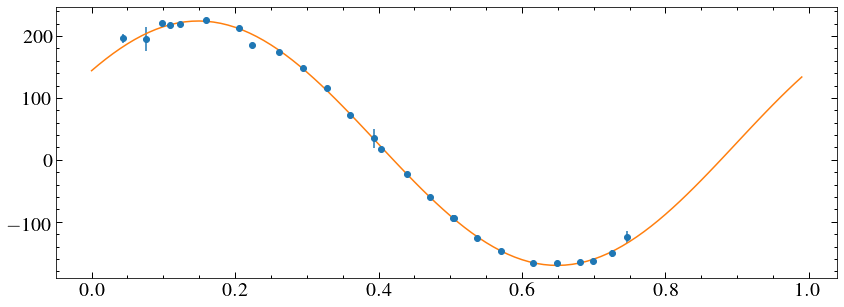

In [110]:
foldt = t/period % 1

plt.errorbar(foldt, dvs, yerr=dves, marker='o', ls='none')
v_offset = max(dvs)-abs(min(dvs))
print(v_offset)
print(max(dvs)-v_offset)
#sin_mod =  models.Sine1D(amplitude=max(dvs)-v_offset, frequency=1/period) +  models.Const1D(v_offset)
sin_mod =  models.Sine1D(amplitude=150, frequency=1, fixed=dict(frequency=True)) +  models.Const1D(50)
sin_fit = fitter(sin_mod, foldt, dvs, weights= 1/dves, maxiter=1000000)
timefit = np.arange(0,1, 0.01)
plt.plot(timefit, sin_fit(timefit))
plt.xlim()
print(sin_fit)
print(1/sin_fit[0].frequency)
#plt.xlim(58601, 58602.5)
#plt.xlim(58167, 58191)
#plt.xlim(1406400,1406500 )

Parameter('fwhm', value=0.00010448171574433357)
Parameter('x_0', value=4.225120080679654) 5.035963363978338e-06


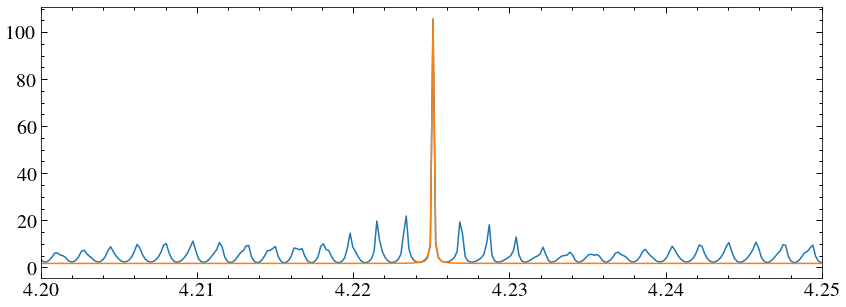

In [120]:
plt.plot(1/frequency, np.sqrt(power))
plt.xlim(4.2,4.25)

l_init =  models.Lorentz1D(100, period, fwhm=0.0001)+models.Const1D(0)
l_fit=fitter(l_init, 1/frequency, np.sqrt(power), maxiter=1000000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(l_fit[0].fwhm)
print(l_fit[0].x_0, fit_e[1])
plt.plot(1/frequency, l_fit(1/frequency))

In [123]:
"""fake_periods = []
i = 0
while i < 10000:
    fake_dv = np.random.normal(dvs, dves)
   # power = LombScargle(t, fake_dv, normalization='model').power(frequency)
    frequency, power = LombScargle(t, fake_dv,dy=dves, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)
    fake_period = 1/frequency[np.argmax(power)]
    fake_periods.append(fake_period)
    i +=1"""


"fake_periods = []\ni = 0\nwhile i < 10000:\n    fake_dv = np.random.normal(dvs, dves)\n   # power = LombScargle(t, fake_dv, normalization='model').power(frequency)\n    frequency, power = LombScargle(t, fake_dv,dy=dves, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)\n    fake_period = 1/frequency[np.argmax(power)]\n    fake_periods.append(fake_period)\n    i +=1"

4.224992224615305 0.002107813625068385


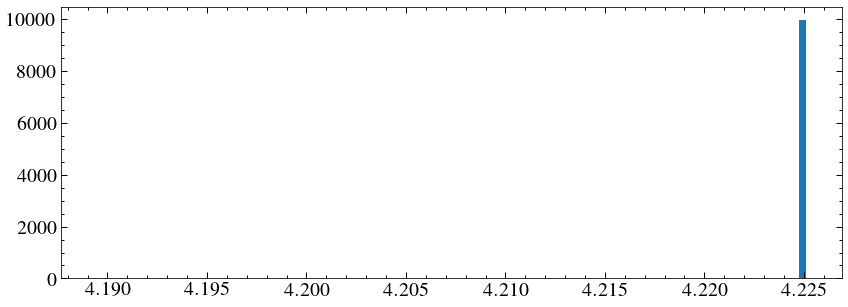

In [124]:
plt.hist(fake_periods, bins=100)
print(np.mean(fake_periods), np.std(fake_periods))
fake_mean = 4.224992224615305
fake_std = 0.002107813625068385

In [125]:
dateord = dates[args]

dateord

array([58168.26580564, 58168.28324501, 58189.08862861, 58189.10606455,
       58601.08955681, 58601.09418082, 58601.15985358, 58601.17048668,
       58601.1785773 , 58602.06879533, 58602.07456747, 58602.08034043,
       58602.0861113 , 58602.09188148, 58602.09997072, 58602.10572851,
       58602.11150645, 58602.11727917, 58602.12305167, 58602.13113316,
       58602.13689975, 58602.14267074, 58602.15420577, 58602.20636724,
       58602.21212944, 58602.21791651])

In [130]:
savdat = Table([dateord, dvs*u.km/u.s, dves*u.km/u.s], names=['MJD','VELOCITY', 'ERROR'])
ascii.write(savdat, 'dv_lists/bd_dvs.ecsv', format='ecsv', overwrite=True)